In [1]:
cd ../dataprocessing

/Users/carverforbes/internships/google/gunshot-detection/activity-recognition/location/lbs/activity/audioset/dataprocessing


In [2]:
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import np_utils
from sklearn import metrics
from sklearn.model_selection import train_test_split

/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
print(os.path.dirname(os.path.realpath('__file__')))

/Users/carverforbes/internships/google/gunshot-detection/activity-recognition/location/lbs/activity/audioset/dataprocessing


In [4]:
debug = False
logging.set_verbosity(logging.INFO)

In [5]:
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
# filenames should adhere to the following order
# [dataset, validation set, test set]
filenames = ['test_set']
labels = ['Gunshot, gunfire']
features_to_extract = ['mfcc']

In [6]:
def get_dataframes():
    length = len(filenames)
    if length == 3:
        dataset_df = ap.output_df(src_dir, dest_dir, filenames[0], labels, features_to_extract)
        evaluation_df = ap.output_df(src_dir, dest_dir, filenames[1], labels, features_to_extract)
        validation_df = ap.output_df(src_dir, dest_dir, filenames[2], labels, features_to_extract)
        dfs = [dataset_df, evaluation_df, validation_df]
    elif length == 2:
        dataset_df = ap.output_df(src_dir, dest_dir, filenames[0], labels, features_to_extract)
        evaluation_df = ap.output_df(src_dir, dest_dir, filenames[1], labels, features_to_extract)
        dfs = [dataset_df, evaluation_df]
    elif length == 1:
        dataset_df = ap.output_df(src_dir, dest_dir, filenames[0], labels, features_to_extract)
        dfs = [dataset_df]
    else:
        raise ValueError('You must have at least one dataset csv and testing data csv')
    return dfs

In [7]:
dfs = get_dataframes()

INFO:absl:The set has 67 examples
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl:Already Downloaded
INFO:absl

In [8]:
dataset_df = dfs[0]
dataset_df.head()

,label,mfcc
0,0,"[-67.90088, 63.705128, -30.782408, 17.39051, -..."
1,0,"[-106.797104, 96.14693, -0.8804454, 15.475855,..."
2,1,"[-327.4217, 22.001167, -5.951601, -2.1868708, ..."
3,0,"[-231.554, 79.097336, -58.210163, 32.53509, -1..."
4,0,"[-38.790012, 82.94961, -12.33035, 6.6264467, -..."


In [9]:
# dataset_scaled = []
# for label, feature in zip(dataset_df.label, dataset_df.mfcc):
#     print(label, feature)
#     example_scaled = [label]
#     scaled_feature = np.mean(feature, axis=0)
#     example.append()
#     break
#     extracted_feature = np.mean(extracted_feature, axis=0)
#     print(extracted_feature)
#     dataset_scaled.append()
# dataset_scaled.head()

Convert features and classification labels into numpy arrays

In [27]:
X = np.array(dataset_df.mfcc.tolist(), dtype=object)
y = np.array(dataset_df.label.tolist())

In [36]:
print(len(X))
print(X.dtype)
print(type(X))
print(type(X[0]))
print(len(X[0]))
# print(X)
print(X[0][0])
print(type((X[0][0])))

57
object
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20
-67.90087890625
<class 'float'>


In [11]:
def get_data_for_model(dfs, ratio):
    length = len(dfs)
    if length == 3:
        train_x = np.array(dfs[0].mfcc.tolist(), dtype=object)
        train_y = np.array(dfs[0].label.tolist())
        test_x = np.array(dfs[1].mfcc.tolist(), dtype=object)
        test_y = np.array(dfs[1].label.tolist())
        val_x = np.array(dfs[2].mfcc.tolist(), dtype=object)
        val_y = np.array(dfs[2].label.tolist())
        return train_x, train_y, val_x, val_y, test_x, test_y
    elif length == 2:
        train_x = np.array(dfs[0].mfcc.tolist(), dtype=object)
        train_y = np.array(dfs[0].label.tolist())
        test_x = np.array(dfs[1].mfcc.tolist(), dtype=object)
        test_y = np.array(dfs[1].label.tolist())
        return train_x, train_y, test_x, test_y
    elif length == 1:
        X = np.array(dataset_df.mfcc.tolist(), dtype=object)
        y = np.array(dataset_df.label.tolist())
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.20, random_state = 42)
        return train_x, train_y, test_x, test_y

# Split the dataset

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

In [24]:
# trying to fix bug:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# It worked!!!
from keras import backend as K
print(type(x_train))
print(x_train.dtype)
print(x_train)
# print(type(y_train))
# x_train = K.cast_to_floatx(x_train)
# # y_train = K.cast_to_floatx(y_train)
# # x_test = K.cast_to_floatx(x_test)
# # y_test = K.cast_to_floatx(y_test)

<class 'numpy.ndarray'>
float32
[[-1.77032806e+02  7.28408508e+01 -5.68112755e+00 -1.30853283e+00
  -1.00413032e-01  7.92805386e+00 -2.46912346e+01 -2.88684201e+00
  -1.08732758e+01  3.22981715e+00 -1.18404350e+01 -1.11427808e+00
  -7.47664404e+00 -2.66045976e+00 -7.25988007e+00  3.61679018e-01
  -9.31327915e+00  2.39765930e+00 -6.09591389e+00 -1.74722242e+00]
 [-1.34117950e+02  9.29501419e+01  1.34619627e+01  1.80492611e+01
   8.91139317e+00  1.28310432e+01  9.51210308e+00  7.21764469e+00
   1.22628088e+01  1.99835415e+01  9.17489529e+00  1.66261654e+01
   1.36621141e+01  7.10424995e+00 -4.08626795e+00  4.96971273e+00
  -5.78119469e+00  5.85053205e-01 -6.08278894e+00  4.33479548e+00]
 [-1.79601944e+02  1.52893005e+02  3.07822895e+00  5.18851242e+01
   2.22138748e+01  8.77847958e+00  6.60843468e+00  7.89993858e+00
  -2.45579123e-01  5.13266659e+00 -1.13561058e+00  3.39362049e+00
  -2.00794673e+00  9.40760076e-01 -2.53137064e+00  2.69281697e+00
  -3.54515886e+00 -1.90872145e+00 -1.93413

In [14]:
data = (x_train, x_test, y_train, y_test)

In [15]:
def visualize_training(history, filename):
    history_dict = history.history
    history_dict.keys()
    acc = history_dict['accuracy']
#     val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
#     val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    
    # "bo" is for "blue dot"
    ax1.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
#     ax1.plot(epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(epochs, acc, 'bo', label='Training acc')
#     ax2.plot(epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='lower right')
    
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


In [16]:
def model_config1(activation, optimizer, metrics):
    model = keras.Sequential([
        keras.Input(shape=(20,)),
        keras.layers.Dense(20, activation=activation),
        keras.layers.Dense(1, activation=activation)
    ])
    model.compile(optimizer=optimizer,
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=metrics)
    return model

In [17]:
def model_train1(model, data, epochs):
    x_train, x_test, y_train, y_test = data
    history = model.fit(x_train,
                        y_train,
                        epochs=epochs,
                        verbose=1,
                        use_multiprocessing=False
    )
    return history

In [18]:
def print_performance(history):
    loss = history.history.get('loss')
    accuracy = history.history.get('accuracy')
    tp = history.history.get('tp')
    fp = history.history.get('fp')
    tn = history.history.get('tn')
    fn = history.history.get('fn')
    print('Loss: {}'.format(loss))
    print('accuracy: {}'.format(accuracy))
    print('True Positives: {}'.format(tp))
    print('False Positives: {}'.format(fp))
    print('True Negatives: {}'.format(tn))
    print('False Negatives: {}'.format(fn))
    prec = []
    rec = []
    f1 = []
    for tp1, fp1 in list(zip(tp, fp)):
        prec.append(precision(tp1, fp1))
    for tp1, fn1 in list(zip(tp, fn)):
        rec.append(recall(tp1, fn1))
    for rec1, prec1 in list(zip(rec, prec)):
        f1.append(f1score(rec1, prec1))
        print('Recall: {}'.format(rec))
    print('Precision: {}'.format(prec))
    print('F1-Score: {}'.format(f1))

In [19]:
def precision(tp, fp):
    sum = tp + fp
    if sum == 0:
        return 0
    return tp / sum

In [20]:
def recall(tp, fn):
    sum = tp + fn
    if sum == 0:
        return 0
    return tp / sum

In [21]:
def f1score(recall, precision):
    sum = recall + precision
    if sum == 0:
        return 0
    return 2 * recall * precision / sum

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 14.2326 - accuracy: 0.0667 - tp: 3.0000 - fp: 42.0000 - tn: 0.0000e+00 - fn: 0.0000e+00    
Epoch 2/20
2/2 [==============================] - 0s 1ms/step - loss: 14.2326 - accuracy: 0.0667 - tp: 3.0000 - fp: 42.0000 - tn: 0.0000e+00 - fn: 0.0000e+00
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 14.2326 - accuracy: 0.0667 - tp: 3.0000 - fp: 42.0000 - tn: 0.0000e+00 - fn: 0.0000e+00
Epoch 4/20
2/2 [==============================] - 0s 1ms/step - loss: 14.2326 - accuracy: 0.0667 - tp: 3.0000 - fp: 42.0000 - tn: 0.0000e+00 - fn: 0.0000e+00
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 14.2326 - accuracy: 0.0667 - tp: 3.0000 - fp: 42.0000 - tn: 0.0000e+00 - fn: 0.0000e+00
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 14.2326 - accuracy: 0.0667 - tp: 3.0000 - fp: 42.0000 - tn: 0.0000e+00 - fn: 0.0000e+00
Epoch 7/20
2/2 [==============================] 

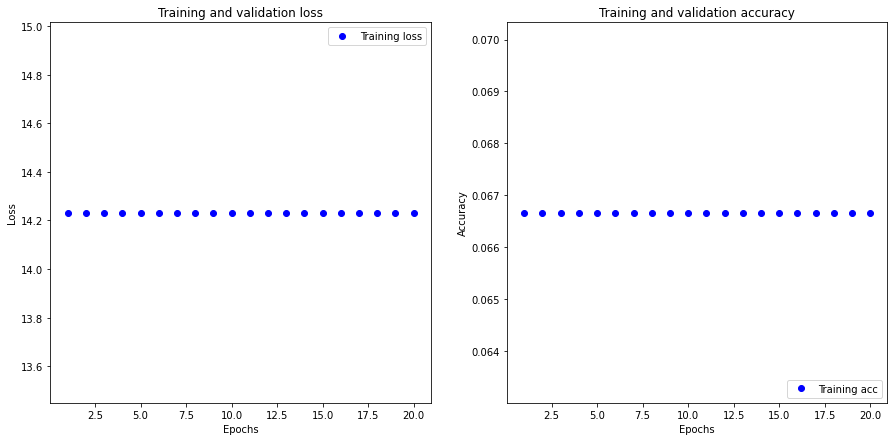

Loss: [14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445, 14.232622146606445]
accuracy: [0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428, 0.06666667014360428]
True Positives: [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
False Positives: [42.0, 42.0, 42.0, 42.0, 42.

In [22]:
path = os.path.join(dest_dir, 'results1')
metrics_list = [['accuracy'], 
                [tf.keras.metrics.TruePositives(name='tp')], 
                [tf.keras.metrics.TrueNegatives()], 
                [tf.keras.metrics.FalseNegatives()], 
                [tf.keras.metrics.FalsePositives()]
               ]
metrics = [
    'accuracy',
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
]
model = model_config1('softmax', 'adam', metrics)
history = model_train1(model, data, 20)
visualize_training(history, path)
print_performance(history)